In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import numba, os, sys, time, pickle, resource, copy
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from sys import path

from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido, attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
import importlib

home_dir = '~'
base_path = "../../../" # Replace this with the path you want CROBAR putting files.
path.append(os.path.join(base_path,'core_repo','CROBAR','python_modules'))
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission

data_path = os.path.join(home_dir,'Research','Solar_Physics','data')
hmi_data_dir = os.path.join(data_path,'SDO','HMI')
aia_data_dir = os.path.join(data_path,'SDO','AIA')
crobar_output_dir = os.path.join(base_path,'model_output')

plt.rcParams.update({'font.size': 18,'figure.figsize':[10,6],'image.origin':'lower'})

/tmp/ipykernel_194698/2591892619.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [37]:
#date='2010/07/25 00:16:30' # The date to use
#datestr='20100725_001630' # A string describing the date for save file purposes
length_unit = u.cm

# date='2021/12/27 02:00:00'
date='2018/02/03 14:10:17'
datestr = date.replace('/','').replace(' ','_').replace(':','')

# Voxel size for CROBAR (0.42 Mm here)
dvox = np.array([(0.42*u.Mm).to(length_unit).value]*3)

# Voxel size for initial points:
flt_dvox = dvox*[1.0,1.0,10.0] # Initial point filtering voxel size
nloops_vol = 50 # Number of initial point randomly selected in the volume
nloops_flux = 1000 # Number of flux weighted initial points

# Value of force-free alpha to use for field line tracing:
# alpha = -5/1.0e11 #*np.mean(1.0/(bounds0[1,0:2]-bounds0[0,0:2])**2)**0.5
alpha = 11.0/1.0e11   ############
alphastr = str(round(alpha/1.0e-11,3))

psf_size_px = 0.7 # Default PSF size in pixels
min_height = 1.0*dvox[2] # Loops must rise at least this high
min_length = 8.0*np.mean(dvox) # Loops must be at least this long

# Start tracing this high above the solar surface:
ivp_z0 = 0.02*dvox[2]
ivp_xpo = 1.0
ivp_clip = 0.99

download = False # Download from VSO
newpoints = 1 # Generate new seed points
newtrace = 1 # Retrace field lines

# Save footpoints to this file
footpoint_savefile = os.path.join(crobar_output_dir,'footpoints_'+datestr+'.pickle')
# Save traced loops to this file:
loop_savefile = os.path.join(crobar_output_dir,'loops_'+datestr+'_'+alphastr+'.pickle')
# Save emission cube to this file:
em3d_savefile = os.path.join(crobar_output_dir,'em3d_'+datestr+'_'+alphastr+'.npy')

# X and y range of solar images to use for SDO/STEREO:
# [x0, y0, xsz0, ysz0] = [-150, 235, 400, 350]
[x0, y0, xsz0, ysz0] = [-110, -200, 250, 300]
[xl, yl, xh, yh] = [x0, y0, x0+xsz0, y0+ysz0]
# X and Y ranges for STEREO A and B:
[xl_sta, xh_sta, yl_sta, yh_sta] = [-1200, -600, -650, -250]
[xl_stb, xh_stb, yl_stb, yh_stb] = [600, 1200, -650, -250]

# Voxels are padded inward from the crop range by this much:
vox_boundpad = np.array([[0.05,0.05,0.001],[-0.05,-0.05,-0.1]])
# Initial points are padded inward from the crop range by this much:
ivp_boundpad = np.array([[0.05,0.05,0.075],[-0.05,-0.05,-0.7]])

scaltemp1 = 1.2e6 # Temperature for estimating scale height of loop profile 1
scaltemp2 = 1.2e6 # Temperature for estimating scale height of loop profile 2
chan1_xpo = 2.0 # Assumed exponential power law index of the temperature response function
zmin0 = 2.63e8 # Minimum height

In [3]:
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
nloops0 = nloops_vol+nloops_flux
flux_factor = dvox[0]*dvox[1]
gfac = 1.0/2.2
length_unit = u.cm

# Massaging the x and y ranges:
cropr_stereoa = [xl_sta,xh_sta,yl_sta,yh_sta]*u.arcsec
cropr_stereob = [xl_stb,xh_stb,yl_stb,yh_stb]*u.arcsec
cropr = [x0-xsz0*(vox_boundpad[0,0]/(1-vox_boundpad[0,0])),x0+xsz0/(1+vox_boundpad[1,0]),
        y0-ysz0*(vox_boundpad[0,1]/(1-vox_boundpad[0,1])),y0+ysz0/(1+vox_boundpad[1,1])]*u.arcsec
cropr0 = [x0, x0+xsz0, y0, y0+ysz0]*u.arcsec

In [4]:
if(download):
    # Download fresh from the VSO:
    #time_range = TimeRange(TimeRange(date,-1800*u.s).start,TimeRange(date,1800*u.s).end)
    #qry_stereo = Fido.search(a.Time(time_range),a.Instrument('SECCHI'),a.Wavelength(284*u.angstrom))
    #sta_hits = search_fido_response(qry_stereo,'STEREO_A')[0]
    #stereoadat_path = Fido.fetch(qry_stereo[sta_hits[0],sta_hits[1]],path=sdo_data_dir)
    #print(stereoadat_path)

    #stb_hits = search_fido_response(qry_stereo,'STEREO_B')[0]
    #stereobdat_path = Fido.fetch(qry_stereo[stb_hits[0],stb_hits[1]],path=sdo_data_dir)
    #print(stereobdat_path)

    time_range = TimeRange(TimeRange(date,-10*u.s).start,TimeRange(date,10*u.s).end)
    qry_aia335 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(335*u.angstrom))
    aia335dat_path = Fido.fetch(qry_aia335[0][0],path=aia_data_dir)[0]

    time_range = TimeRange(TimeRange(date,-10*u.s).start,TimeRange(date,10*u.s).end)
    qry_aia171 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(171*u.angstrom))
    aia171dat_path = Fido.fetch(qry_aia171[0][0],path=aia_data_dir)[0]

    time_range = TimeRange(TimeRange(date,-60*u.s).start,TimeRange(date,60*u.s).end)
    qry_hmi = Fido.search(a.Time(time_range),a.Instrument('HMI'),a.Physobs('LOS_magnetic_field'))
    magnetogram_path = Fido.fetch(qry_hmi[0][0],path=hmi_data_dir)[0]
else:
    # These filenames may be need to be updated if its redownloaded or other data is used:
    #stereoadat_path = os.path.join(sdo_data_dir,'20100725_001630_n4eua.fts')
    #stereobdat_path = os.path.join(sdo_data_dir,'20100725_001630_n4eub.fts')

    # aia335dat_path = os.path.join(sdo_data_dir,'aia_lev1_335a_2021_12_27t02_00_00_62z_image_lev1.fits')
    # aia171dat_path = os.path.join(sdo_data_dir,'aia_lev1_171a_2021_12_27t01_59_57_34z_image_lev1.fits')
    # magnetogram_path = os.path.join(sdo_data_dir,'hmi_m_45s_2021_12_27_02_01_30_tai_magnetogram.fits')

    aia335dat_path = os.path.join(aia_data_dir,'aia_lev1_335a_2018_02_03t14_10_12_62z_image_lev1.fits')
    aia171dat_path = os.path.join(aia_data_dir,'aia_lev1_171a_2018_02_03t14_10_09_35z_image_lev1.fits')
    magnetogram_path = os.path.join(hmi_data_dir,'hmi_m_45s_2018_02_03_14_10_30_tai_magnetogram.fits')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [5]:
aiadat_path = aia335dat_path
print(aia335dat_path,aia171dat_path,magnetogram_path)

/home/jplowman/Research/Solar_Physics/data/SDO/AIA/aia_lev1_335a_2018_02_03t14_10_12_62z_image_lev1.fits /home/jplowman/Research/Solar_Physics/data/SDO/AIA/aia_lev1_171a_2018_02_03t14_10_09_35z_image_lev1.fits /home/jplowman/Research/Solar_Physics/data/SDO/HMI/hmi_m_45s_2018_02_03_14_10_30_tai_magnetogram.fits


In [6]:
# Load and crop the magnetogram:
magnetogram = Map(magnetogram_path)#.rotate(order=3)
blc=SkyCoord(cropr[0],cropr[2],frame=magnetogram.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=magnetogram.coordinate_frame)
magnetogram = magnetogram.submap(blc,top_right=trc)

# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram,lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

rsun_cm = magnetogram.center.rsun.to(length_unit).value

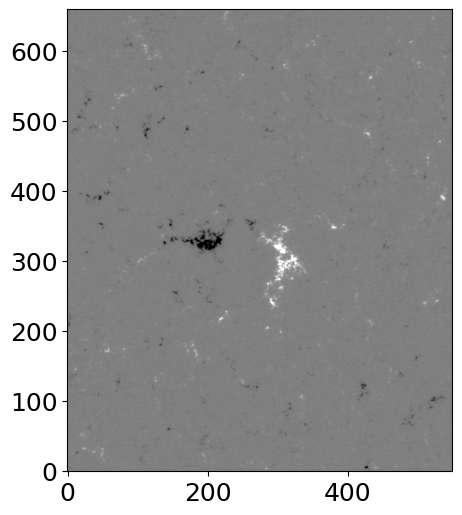

In [7]:
plt.imshow(np.flipud(np.fliplr(magnetogram.data)),cmap=plt.get_cmap('gray'),vmin=-500,vmax=500)

In [8]:
# Set up boundaries for overall region:
bounds0 = np.array([[np.min(c),np.max(c)] for c in mag_coords]).T
bounds0[1,2] = bounds0[0,2] + 0.625*np.min(bounds0[1,0:2]-bounds0[0,0:2])

heights = (mag_coords[0]**2+mag_coords[1]**2+(rsun_cm+mag_coords[2])**2)**0.5 - rsun_cm

# Boundaries for field line tracing are set slightly larger to avoid
# issues when an initial point falls outside the boundary:
tracer_bounds = copy.deepcopy(bounds0)
tracer_bounds[0,0] -= 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[0,1] -= 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[1,0] += 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[1,1] += 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[0,2] = np.max(heights)
tracer_bounds[1,2] = tracer_bounds[0,2] + bounds0[1,2]-bounds0[0,2] # np.max(mag_coords[2,:,:,:]) - bounds0[0,2]

# Get coordinate grids (see coord_grid.py for details of these)
def bounds2grid(bounds0,dvox,offsets=None,pad=None,frame=None):
    if(offsets is None): offsets = 0.5+0.0*dvox
    if(pad is None): pad = np.zeros([2,len(dvox)])
    if(frame is None): frame = np.arange(len(dvox))
    bounds = bounds0+pad*(bounds0[1]-bounds0[0])
    nvox = np.floor((bounds[1]-bounds[0])/dvox).astype(np.int32)
    vox_origin = bounds[0]+offsets*(bounds[1]-bounds[0]-nvox*dvox)
    return coord_grid(nvox,vox_origin,np.diag(dvox),frame)

# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,dvox,offsets=[0.5,0.5,0.0],pad=vox_boundpad)
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,flt_dvox,offsets=[0.5,0.5,0.0])

In [9]:
# Field values and coordinates used for tracing the magnetogram 
# (commented out code will bin it down by a factor of 2, but largely not needed with the MDI 
# magnetogram used in this example):
mag_trace = bindown2(mag[:,:,0],2)/4
mag_coords_trace = np.array([bindown2(xa[:,:,0],2)/4 for xa in mag_coords])

In [10]:
if(newpoints):
    ivp_bounds = tracer_bounds+ivp_boundpad*(tracer_bounds[1]-tracer_bounds[0])
    volume_initial_points = volume_seed_points(nloops_vol, ivp_bounds)
    #fluxw_initial_points = fluxweighted_seed_points2(nloops_flux, mag, mag_coords, ivp_bounds, z0=ivp_z0, xpo=ivp_xpo, clip=ivp_clip)
    fluxw_initial_points = hilbert_seed_points(nloops_flux, mag, mag_coords, ivp_z0, rsun=rsun_cm)
    initialpoint_dict = {'xydomain':[x0,y0,xsz0,ysz0], 'vox_boundpad':vox_boundpad, 'ivp_boundpad':ivp_boundpad, 
                         'dvox':dvox, 'min_height':min_height, 'min_length':min_length, 'magnetogram_path':magnetogram_path, 
                         'date':date, 'datestr':datestr, 'magnetogram':magnetogram, 'mag':mag, 'mag_coords':mag_coords,
                         'ivp_bounds':ivp_bounds, 'ivp_z0':ivp_z0, 'ivp_xpo':ivp_xpo, 'ivp_clip':ivp_clip, 'cropr':cropr,
                         'cropr0':cropr0, 'vox_grid':vox_grid, 'volume_initial_points':volume_initial_points, 
                         'fluxw_initial_points':fluxw_initial_points, 'flt_grid':flt_grid}

    filehandler = open(footpoint_savefile,"wb")
    pickle.dump(initialpoint_dict,filehandler)
    filehandler.close()
if(not(newpoints)):
    file = open(footpoint_savefile,'rb')
    initialpoint_dict = pickle.load(file)
    file.close()
    fluxw_initial_points = initialpoint_dict['fluxw_initial_points']
    volume_initial_points = initialpoint_dict['volume_initial_points']
    ivp_bounds = initialpoint_dict['ivp_bounds']
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [11]:
# Plot the initial points over the magnetogram:
fluxw_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in fluxw_initial_points]
volume_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in volume_initial_points]

fluxw_initial_pt_pix = np.vstack(fluxw_initial_pt_pix)
volume_initial_pt_pix = np.vstack(volume_initial_pt_pix)

(0.0, 660.0)

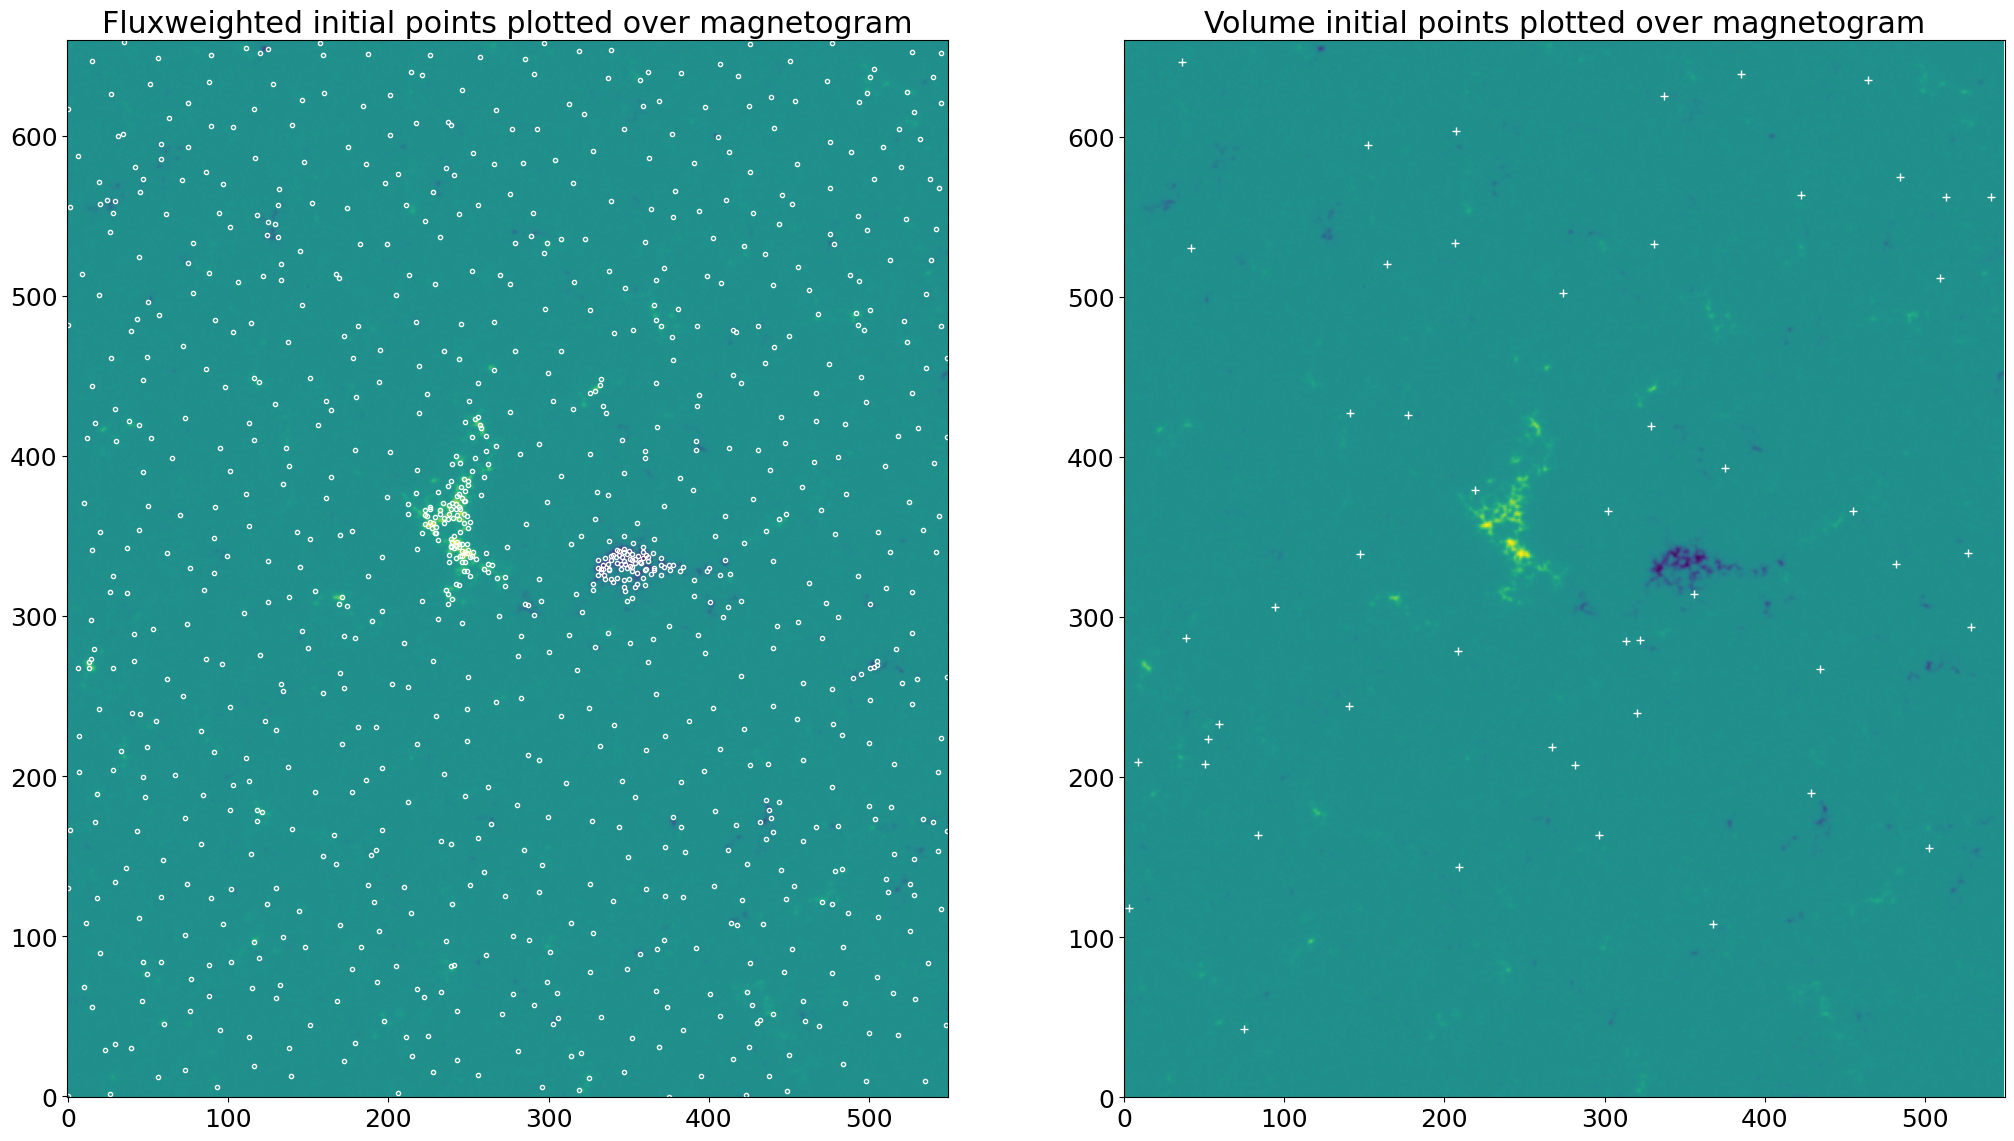

In [12]:
fig = plt.figure(figsize=[25,30])
extent = np.array([bounds0[0,0],bounds0[1,0],bounds0[0,1],bounds0[1,1]])/1.0e8

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax1.plot(fluxw_initial_pt_pix[:,1],fluxw_initial_pt_pix[:,0],'.',color='white', markerfacecolor='none')
ax1.set(title='Fluxweighted initial points plotted over magnetogram')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax2.plot(volume_initial_pt_pix[:,1],volume_initial_pt_pix[:,0],'+',color='white')
ax2.set(title='Volume initial points plotted over magnetogram')
plt.xlim(0,mag.shape[1])
plt.ylim(0,mag.shape[0])

In [13]:
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [14]:
# Trace field lines if newtrace is true:
if(newtrace):
    fieldlines = forcefree_field.tracer(use_points, mag_trace, mag_coords_trace, bounds=tracer_bounds, alpha=alpha, rtol=1.0e-5,atol=0.001*dvox[0], boundrad=magnetogram.center.rsun.to(u.cm).value)
    filehandler = open(loop_savefile,"wb")
    pickle.dump(fieldlines,filehandler)
    filehandler.close()
# Otherwise reload from the previously specified file:
if(newtrace==0):
    file = open(loop_savefile,'rb')
    fieldlines = pickle.load(file)
    file.close()


Done with line  49  at  16.5035080909729  s
Done with line  99  at  29.154896020889282  s
Done with line  149  at  36.12860918045044  s
Done with line  199  at  43.40243339538574  s
Done with line  249  at  50.3847074508667  s
Done with line  299  at  62.104546546936035  s
Done with line  349  at  76.89977502822876  s
Done with line  399  at  90.09029340744019  s
Done with line  449  at  102.0952136516571  s
Done with line  499  at  115.34599876403809  s
Done with line  549  at  128.15621519088745  s
Done with line  599  at  136.91619396209717  s
Done with line  649  at  144.4482433795929  s
Done with line  699  at  152.00518369674683  s
Done with line  749  at  157.849360704422  s
Done with line  799  at  164.24828791618347  s
Done with line  849  at  170.72663760185242  s
Done with line  899  at  176.63085842132568  s
Done with line  949  at  183.90084862709045  s
Done with line  999  at  190.6450617313385  s
Done with line  1049  at  197.66419506072998  s


In [15]:
# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
[fieldlines_resamp,lengths] = resample_loops(fieldlines[0],tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm)
# Filter out loops whose footpoints fall too close together:
[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, lmin=min_length, zmin = min_height, rcurv=rsun_cm)
nloops = len(fieldlines_filter)
print(nloops0,nloops)


1.1442718505859375 1.144256591796875 74 76 1 76
1.1442718505859375 1.144256591796875 96 97 1 97
1.1442718505859375 1.144256591796875 71 72 1 72
1.1442718505859375 1.144256591796875 82 83 1 83
1.1442718505859375 1.144256591796875 120 121 1 121
1.1442718505859375 1.1442718505859375 74 74 1 74
1.1442718505859375 1.144256591796875 77 77 1 78
1.1442718505859375 1.1442718505859375 83 83 1 83
1.1442718505859375 1.1442718505859375 84 84 1 84
1.1442718505859375 1.144256591796875 83 84 1 84
1.1442718505859375 1.144256591796875 82 83 1 83
1.1442718505859375 1.144256591796875 48 49 1 49
1.1442718505859375 1.1442718505859375 76 76 1 76
1.1442718505859375 1.144256591796875 59 60 1 60
1.1442718505859375 1.144256591796875 73 74 1 74
1.1442718505859375 1.144256591796875 67 68 1 68
1.1442718505859375 1.144256591796875 94 95 1 95
1.1442718505859375 1.144256591796875 103 104 1 104
1.1442718505859375 1.1442718505859375 75 75 1 75
1.1442718505859375 1.144256591796875 75 76 1 76
1.1442718505859375 1.14427185

In [16]:
# import label_loop_regions
# importlib.reload(label_loop_regions)
# from label_loop_regions import label_loop_regions

# Create core voxel cube identifying every voxel with a loop:
[loopids, loopid_info, voxel_loop_lengths] = label_loop_regions(fieldlines_filter, lengths_filter, vox_grid)

Total number of loop points =  92156
Memory usage:  664112  kb
Computing Voronoi cells:
Done computing Voronoi cells, elapsed time= 10.981316328048706
Memory usage: 2175632 (kb)
Memory usage:  2175632  kb
Number of Chunks:  90
Checked chunk 3 , elapsed time: 3.206085443496704 s, Memory usage: 2175632 kb
Checked chunk 7 , elapsed time: 8.947632312774658 s, Memory usage: 2175632 kb
Checked chunk 11 , elapsed time: 14.368513584136963 s, Memory usage: 2175632 kb
Checked chunk 15 , elapsed time: 18.148614168167114 s, Memory usage: 2175632 kb
Checked chunk 19 , elapsed time: 21.753880977630615 s, Memory usage: 2175632 kb
Checked chunk 23 , elapsed time: 25.1035737991333 s, Memory usage: 2175632 kb
Checked chunk 27 , elapsed time: 30.08070683479309 s, Memory usage: 2175632 kb
Checked chunk 31 , elapsed time: 36.554792404174805 s, Memory usage: 2175632 kb
Checked chunk 35 , elapsed time: 38.84388303756714 s, Memory usage: 2175632 kb
Checked chunk 39 , elapsed time: 41.55867576599121 s, Memory 

In [19]:
limb_mask = get_limb(vox_grid,rsun_cm)

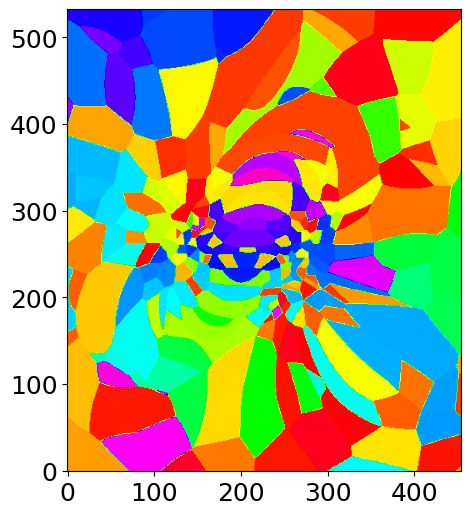

In [20]:
# This is a slice of the voxel label cube at a particular height with the limb mask applied,
# showing each loop as a different color
indx = 75
plt.imshow((limb_mask[:,:,indx]*loopids[:,:,indx] % 200).T, origin='lower',cmap=plt.get_cmap('gist_rainbow'))

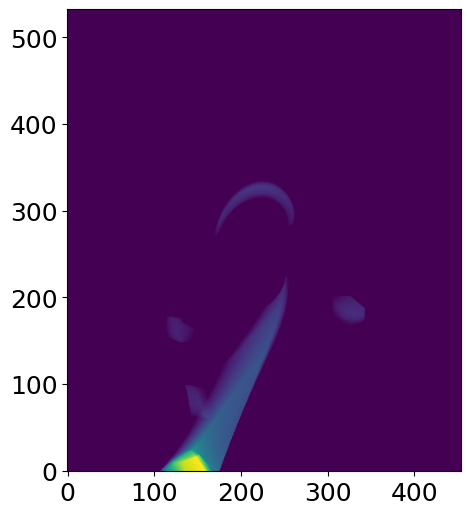

In [21]:
# This is a sum through the cube with every 5th loop illuminated:
plt.imshow(np.sum(limb_mask*(loopids % 100 == 0),axis=2).T)

In [22]:
import reconstruct_2comp_3Dloops
importlib.reload(reconstruct_2comp_3Dloops)
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission


# Crop the data for the reconstruction in a bit compared to the cube. This improves the ability of the 
# reconstruction to fit the data, although it does also mean that the edges of the reconstruction are 
# underconstrained. 
cropr = cropr0+np.array([10,-10,10,-10])*u.arcsec


# Compute the forward matrix from the field-aligned regions to the data:
[amat,modelinputs] = compute_fwdmat(aiadat_path, None, loopids, loopid_info,
                                    vox_grid, cropr, magnetogram, voxel_loop_lengths, curvature=False, 
                                    vox_mask=limb_mask, xpo1 = chan1_xpo, xpo2 = chan1_xpo, temp1=scaltemp1, 
                                    psf_size_px=0.4, zmin=np.min(mag_coords[2]), temp2=scaltemp2, asym=True)

/home/jplowman/Research/Solar_Physics/data/SDO/AIA/aia_lev1_335a_2018_02_03t14_10_12_62z_image_lev1.fits None 1200000.0 1200000.0 2.0 2.0 None None 6000.0 500.0 None -1747156785.2866218 3 None 0.4 True False None None None None None None None None None 0.3333333333333333 1.0
Memory usage: 2175632 (kb)
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.98749001, -9.10788124, 1.47449268e+11)>): (x, y, z) in cm
    (-9.47972897e+09, -1.1259092e+10, 6.78871018e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.300, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.98749001, -9.10788124, 1.47449268e+11)>): (x, y, z) in cm
    (9.54627103e+09, -1.1259092e+10, 6.78871018e+10)>
<SkyCoord (Heliocentric: obstime=None, observer=<HeliographicStonyhurst Coordinate (obstime=2018-02-03T14:09:23.30

In [23]:
# Error estimates for the reconstruction:
chan1_err = estimate_aia_error(modelinputs['map'], channel = 'AIA'+modelinputs['map'].meta['wave_str'])
# Reconstruct using the forward matrix:
solution = reconstruct(amat, modelinputs, reg_fac=0.15, dat_xpo=1, errs=chan1_err, solver_tol=1.0e-5)

1.18 4.523759498470271 32.0
Overall regularization factor: 3.93369209048104e-08
516.695531574569 516.695531574569 6.247453787248331 6.247453787248331
1.45 s i = 0 chi2 = 2.21 step size = 0.3 reg. param. = 0.0 chi2 change = 0.66955 reg. change = 8e-05
0 6.174569873367463 0.5271216961645441 4.397951790755159 9.480795339315991
516.695531574569 516.695531574569 4.397951790755159 9.480795339315991
2.57 s i = 1 chi2 = 1.13 step size = 0.85 reg. param. = 0.0 chi2 change = 1.08653 reg. change = 7e-05
1 5.606342030718772 1.2014326917087375 -0.9060434473051577 9.056389722823196
516.695531574569 516.695531574569 -0.9060434473051577 9.056389722823196
3.73 s i = 2 chi2 = 0.86 step size = 0.67 reg. param. = 0.0 chi2 change = 0.27012 reg. change = 2e-05
2 5.036531441885855 1.7871020911054898 -4.389882071231266 8.9192008590321
516.695531574569 516.695531574569 -4.389882071231266 8.9192008590321
5.04 s i = 3 chi2 = 0.76 step size = 0.5 reg. param. = 0.0 chi2 change = 0.09355 reg. change = 1e-05
3 4.648

In [24]:
# The product of the field-aligned region solution vector and the forward matrix is the reconstruction's estimate
# of the AIA image. amat and the solution use a scaled version of the matrix which greatly improves convergence of 
# Krylov methods, hence the loop_weights factors. For a single forward matrix rescaling by the loop weights below
# isn't necessary, but for multiple forward matrices (e.g., multiple perspectives) it is:
soln = copy.deepcopy(solution[0])/modelinputs['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(modelinputs['loop_weights']*soln)).reshape(modelinputs['map'].data.shape)

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

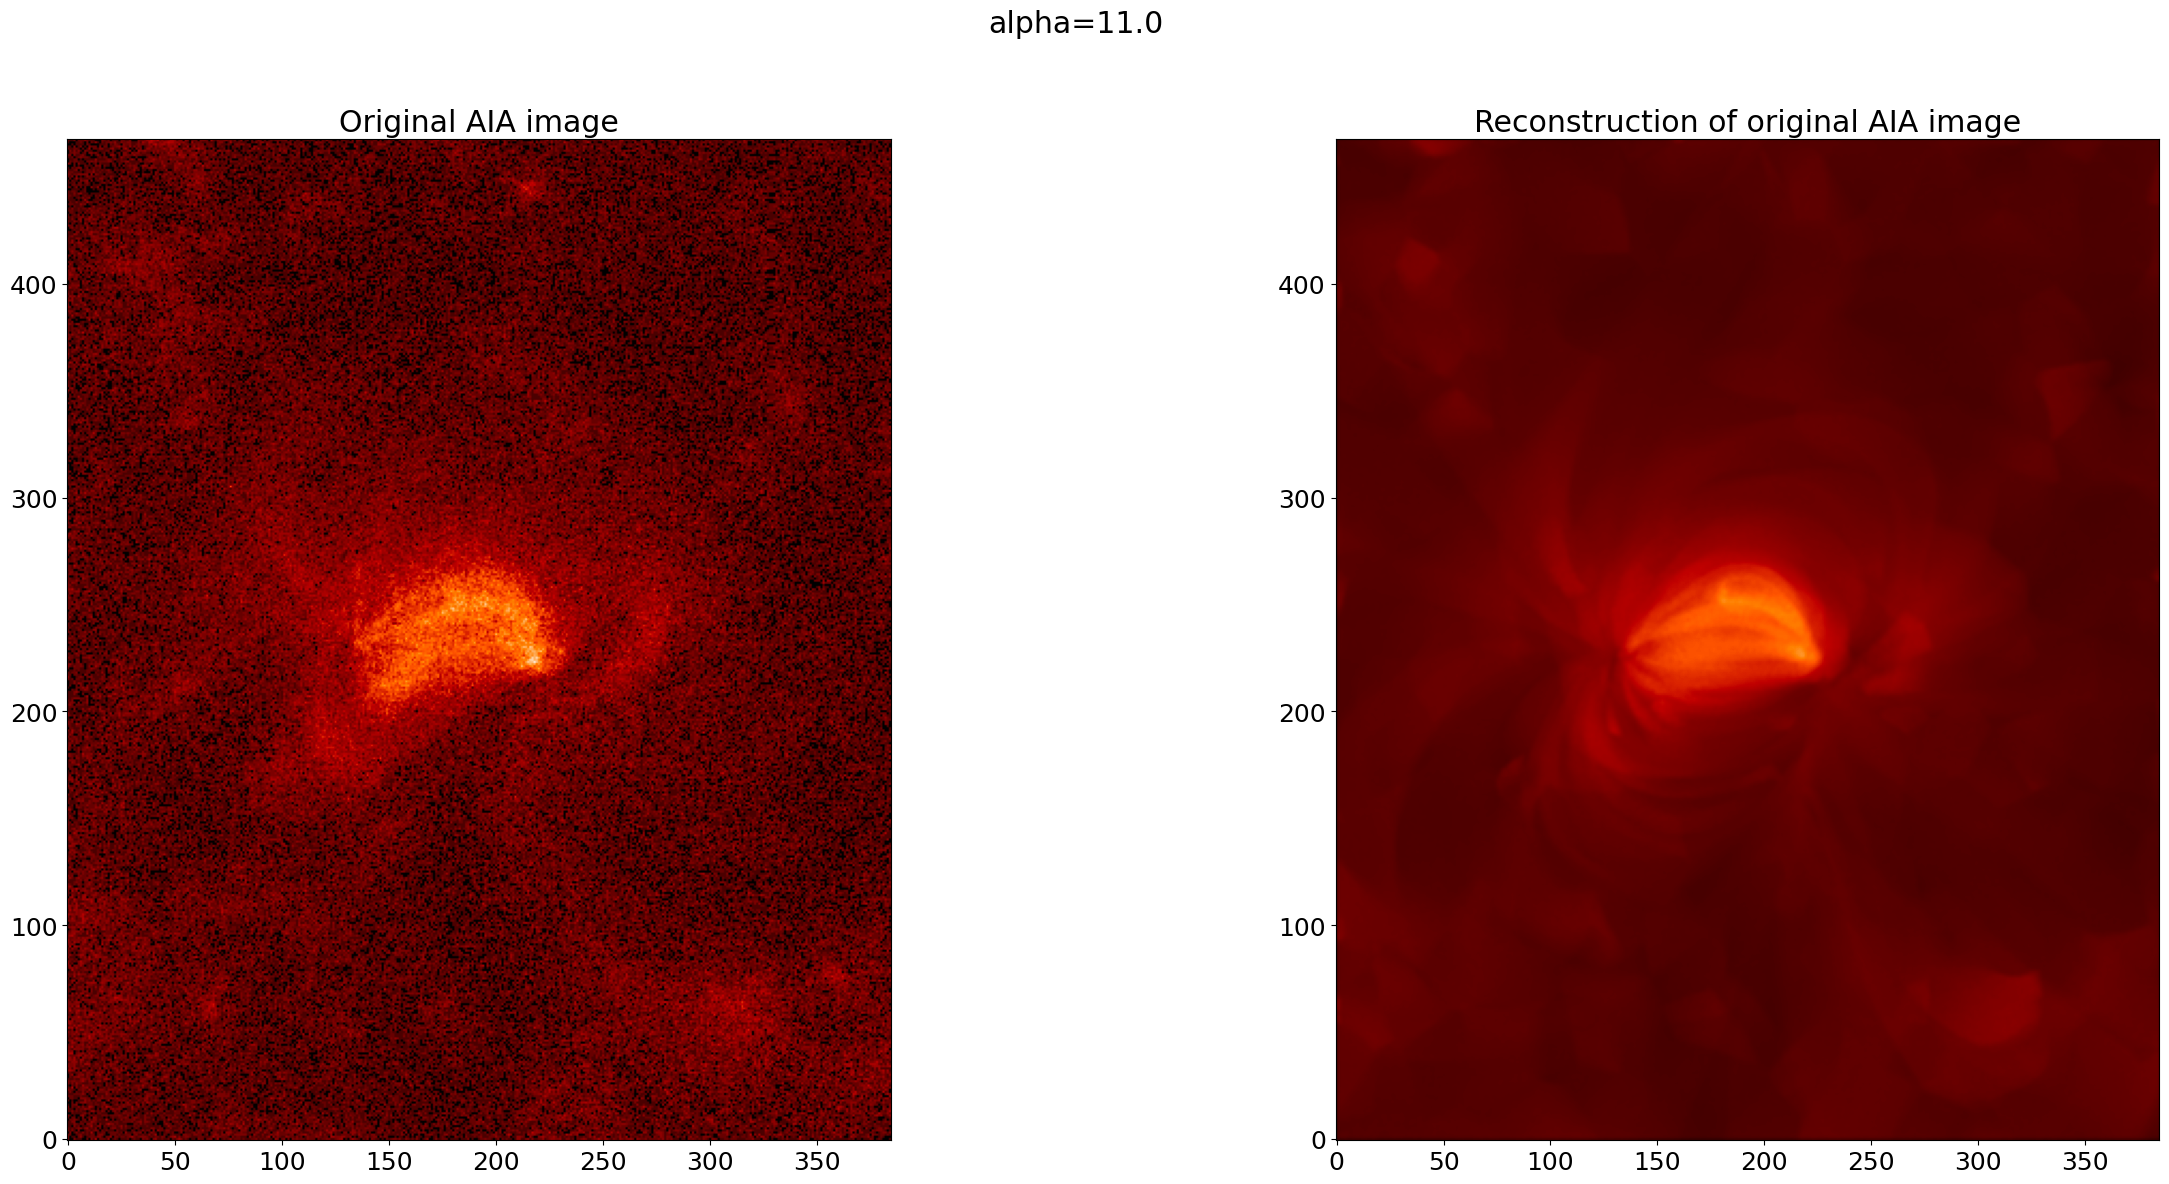

In [31]:
pltmax = 35

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[30,13])
plt.suptitle('alpha='+alphastr)
axes[0].imshow(np.abs(modelinputs['map'].data)**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [32]:
# Expand the solution into a 3D emission cube: 
em3d = get_3d_emission(solution[0], modelinputs, vox_grid, loopids, voxel_loop_lengths, loopid_info, zmin=np.min(mag_coords[2]))

Memory usage: 2175632 (kb)
0 283 -1747156785.2866218 11928000000.0


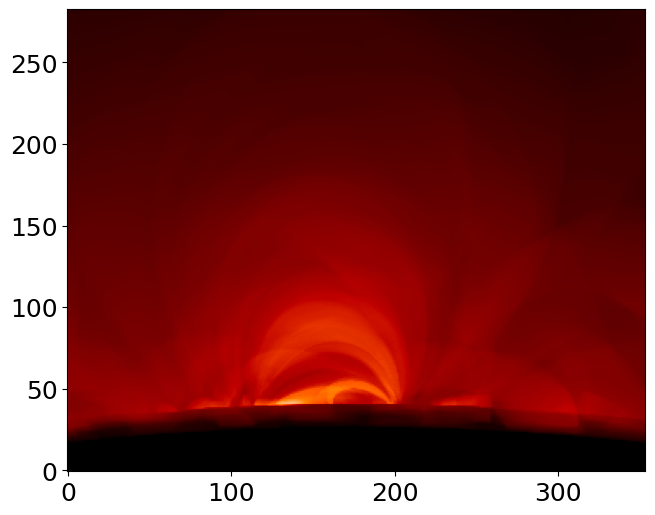

In [35]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from the pole):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=1).T**gfac,vmin=0,vmax=1.0e-6**gfac,cmap=plt.get_cmap('gist_heat'))

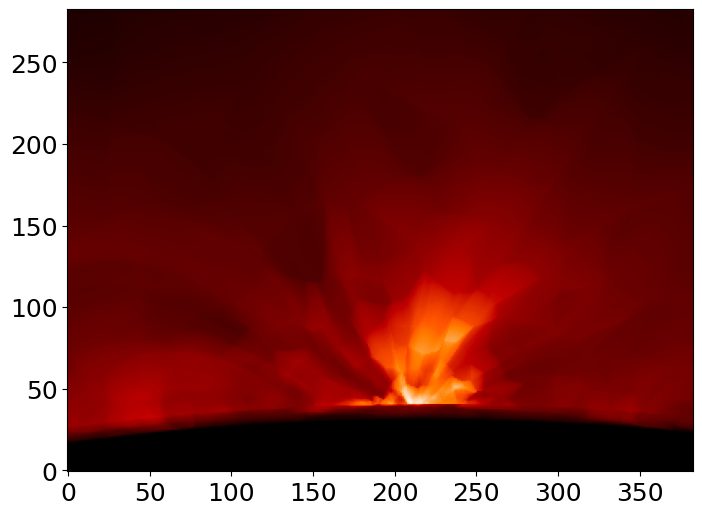

In [36]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from ecliptic latitude):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=0).T**gfac,vmin=0,vmax=1.0e-6**gfac,cmap=plt.get_cmap('gist_heat'))

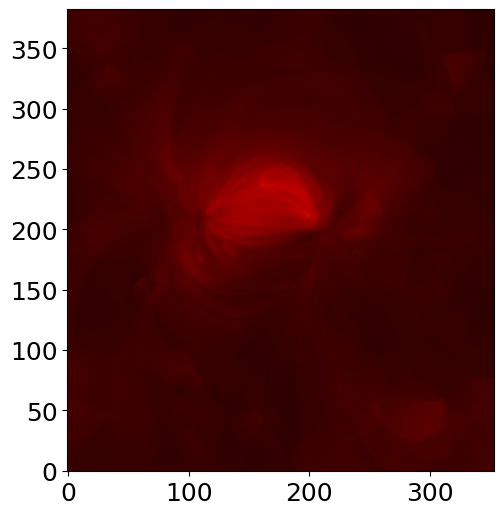

In [29]:
# Plot the x-y projection through the cube (e.g., as viewed from directly overhead):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=2).T**gfac,vmin=0,vmax=2.0e-6**gfac,cmap=plt.get_cmap('gist_heat'))

In [75]:
em3d_out = em3d[50:-50,50:-100,:]*limb_mask[50:-50,50:-100,:]
em3d_norm = np.max(em3d_out)
print(em3d_norm*dvox[2])
mask_out = limb_mask[50:-50,50:-100,:]
em3d_out = (254*(em3d_out/np.max(em3d_out))**0.5).astype(np.uint8)
em3d_out[mask_out==False] = 255

0.9934081504070491


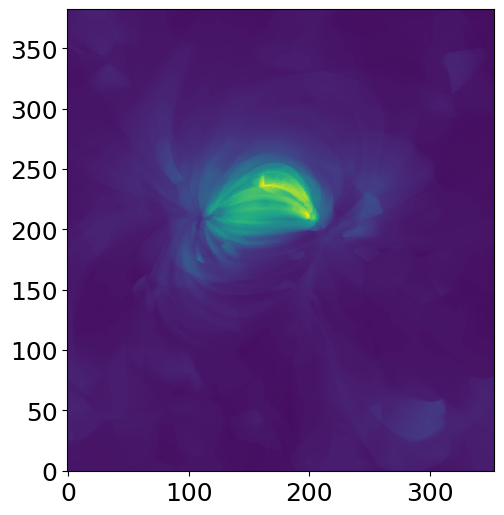

In [82]:
plt.imshow(np.sum(em3d_norm*dvox[2]*mask_out*(em3d_out.astype(np.float32)/254)**2,axis=2).T,vmin=0,vmax=20)

In [61]:
np.save(em3d_savefile, em3d_out, allow_pickle=False) 

In [85]:
modelinputs['map'].save(os.path.join(crobar_output_dir,'cropped_AIA335.fits'))

In [94]:
print('voxmin =',vox_grid.origin)
print('dvox =',np.diag(vox_grid.fwd))

voxmin = [-9.50072897e+09 -1.12800920e+10 -1.73389816e+09]
dvox = [42000000. 42000000. 42000000.]
